In [1]:
import UWGeodynamics as GEO
import numpy as np
import math as math
from scipy.linalg import solve as linSolve
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.interpolate import interp1d
import glucifer
from mpi4py import MPI

comm = MPI.COMM_WORLD
CPUsize=comm.Get_size()

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

velocity = 1. * u.centimeter / u.year
model_length = 120. * u.kilometer
bodyforce = 2400. * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling["[length]"] = KL
GEO.scaling["[time]"] = Kt
GEO.scaling["[mass]"] = KM

In [3]:
Model = GEO.Model(
    elementRes=(240, 30),
    minCoord=(0. * u.kilometer, -6. * u.kilometer),
    maxCoord=(120. * u.kilometer, 9. * u.kilometer),
    gravity=(0.0, -9.81 * u.meter / u.second**2))
Model.outputDir = "lowresThrustWedge_r"

In [4]:
Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

In [5]:
stickyAirLayer = Model.add_material(
    name="Sticky Air",
    shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))
plasticLayer = Model.add_material(
    name="Plastic",
    shape=GEO.shapes.Layer(top=stickyAirLayer.bottom, bottom=-5 * u.kilometer))
frictLayer = Model.add_material(
    name="Decol",
    shape=GEO.shapes.Layer(top=plasticLayer.bottom, bottom=-5.5 * u.kilometer))
rigidBase = Model.add_material(
    name="Ridid Base Layer",
    shape=GEO.shapes.Layer(top=frictLayer.bottom, bottom=Model.bottom))


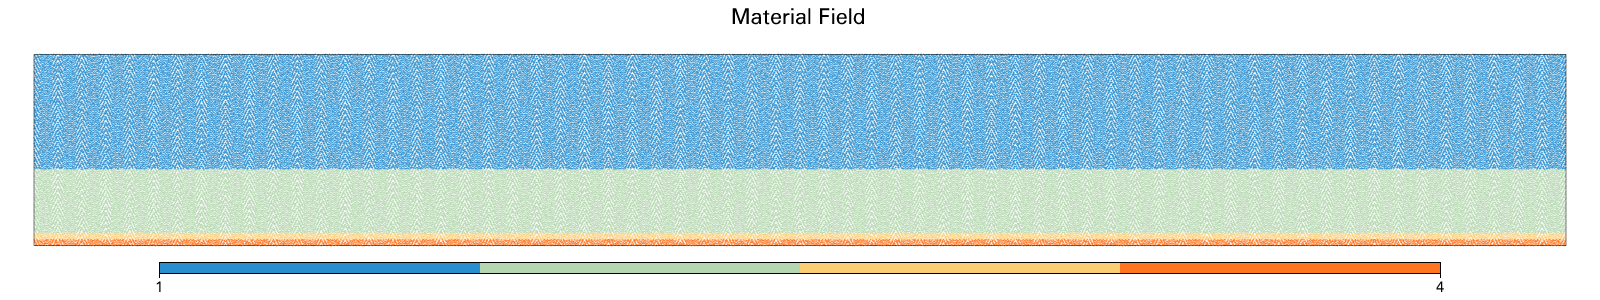

'Materials_initial.png'

In [6]:
Model.plot.material(figsize=(1600, 300), fn_size=2).save("Materials_initial")

In [7]:
stickyAirLayer.density = 1. * u.kilogram / u.metre**3
plasticLayer.density = 2400. * u.kilogram / u.metre**3
frictLayer.density = 2400. * u.kilogram / u.metre**3
rigidBase.density = 2400. * u.kilogram / u.metre**3

In [8]:
stickyAirLayer.viscosity = GEO.ConstantViscosity(1e18 * u.pascal * u.second)
rigidBase.viscosity = GEO.ConstantViscosity(1e23 * u.pascal * u.second)

plasticLayer.minViscosity = 1e18 * u.pascal * u.second
frictLayer.minViscosity = 1e18 * u.pascal * u.second

In [9]:
plasticLayer.plasticity = GEO.DruckerPrager(
    cohesion=20 * u.megapascal,
    #cohesionAfterSoftening=3 * u.mpascal,
    frictionCoefficient=np.tan(np.radians(30.0)),
    #frictionAfterSoftening=np.tan(np.radians(15.0))
)

frictLayer.plasticity = GEO.DruckerPrager(
    cohesion=0.1 * u.megapascal,
    #cohesionAfterSoftening=0.01 * u.pascal,
    frictionCoefficient=np.tan(np.radians(10.0)),
    #frictionAfterSoftening=np.tan(np.radians(10.0))
)


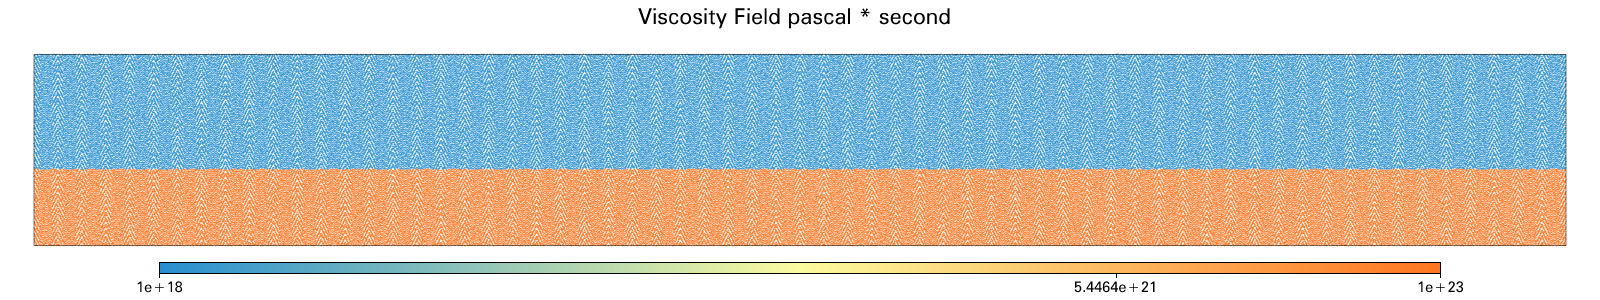

'Viscosity_initial.png'

In [10]:
Model.plot.viscosity(figsize=(1600, 300), fn_size=2).save("Viscosity_initial")

In [11]:
conditions = [(Model.y <= GEO.nd(rigidBase.top), GEO.nd(-velocity)),
              (True, GEO.nd(0. * u.centimeter / u.year))]

VelocityBcs = Model.set_velocityBCs(
    left=[conditions, 0.],
    right=[-velocity, None],
    top=[None, None],
    bottom=[-velocity, 0.])


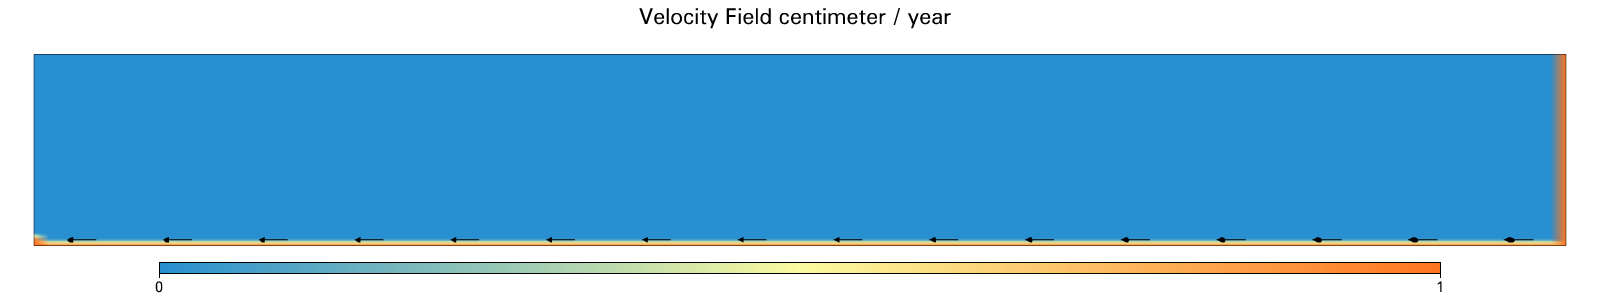

In [12]:
Fig = Model.plot.velocityField(figsize=(1600, 300),scaling=.3).save("Velocity_initial")

In [13]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [14]:
Model.init_model()

In [15]:
topoNum = 4*Model.elementRes[0]+1
topostp = (GEO.nd(Model.maxCoord[0]) - GEO.nd(Model.minCoord[0])) / (topoNum - 1)
gridt = np.zeros((6, topoNum))
gridt[0, :] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), topoNum)
gridt[1, :] = GEO.nd(stickyAirLayer.bottom)# Initial z-coordinate for topography

In [16]:
def plotFigures(fnSize=2,figSize=(1600, 300)):
    Model.plot.viscosity(figsize=figSize,colours='spectral',fn_size=fnSize,valueRange=[1e18,1e23],fn_mask=Model.materialField>stickyAirLayer.index).save(Model.outputDir+'/ViscoSity_ '+str(Model.time)+'.png')

    Model.plot.material(figsize=figSize,fn_size=fnSize,fn_mask=Model.materialField>stickyAirLayer.index).save(Model.outputDir+'/Material_ '+str(Model.time)+'.png')

    Model.plot.plasticStrain(figsize=figSize,colours='cubelaw2',fn_size=fnSize,fn_mask=Model.materialField>stickyAirLayer.index,valueRange=[0,4]).save(Model.outputDir+'/PlasticStrain '+str(Model.time)+'.png')

    FigSr = glucifer.Figure(figsize=figSize,quality=3,title="Strain Rate Field 1.0/seconds",boundingBox= ((0.0, -0.05), (1.0, 0.075)))
    fact=GEO.Dimensionalize(1.0, 1./u.seconds).magnitude
    FigSr.Points(Model.swarm,Model.strainRateField* fact,logScale=True,figsize=figSize,colours='spectral',valueRange=[1e-18,1e-13],fn_mask=Model.materialField>stickyAirLayer.index,fn_size=fnSize)
    FigSr.show()
    FigSr.save(Model.outputDir+'/strainRate '+str(Model.time)+'.png')
    return

In [17]:
def SurfaceVeloEval(mesh=Model.mesh,velocityField=Model.velocityField,minX=GEO.nd(Model.minCoord[0]),maxX=GEO.nd(Model.maxCoord[0])):
    global gridt
    gridt[3:6, :] = 0.0
    tmp = np.where((gridt[0, :] >= minX) & (gridt[0, :] <= maxX) &
                   (gridt[0, :] >= mesh.data[0:mesh.nodesLocal, 0].min()) &
                   (gridt[0, :] <= mesh.data[0:mesh.nodesLocal, 0].max())
                   & (gridt[1, :] <= mesh.data[0:mesh.nodesLocal, 1].max()))[0]

    if len(tmp) > 0:
        tmp2 = velocityField.evaluate(np.squeeze(gridt[0:2, tmp]).T)
        gridt[3, tmp] = tmp2.T[0, :]
        gridt[4, tmp] = tmp2.T[1, :]

        tmp = np.where((gridt[0, :] > minX) & (gridt[0, :] < maxX) & (
            (gridt[0, :] == mesh.data[0:mesh.nodesLocal, 0].min())
            | (gridt[0, :] == mesh.data[0:mesh.nodesLocal, 0].max())))[0]
        # boundary between two cpus, there velocity is reduced
        if len(tmp) > 0:
            # import ipdb; ipdb.set_trace()
            print 'hgn', tmp, gridt[0:2, tmp], np.squeeze(gridt[0:2, tmp]).T
            if len(tmp) == 1:
                tmp2 = velocityField.evaluate((gridt[0, tmp][0],
                                               gridt[1, tmp][0]))
            else:
                tmp2 = velocityField.evaluate(np.squeeze(gridt[0:2, tmp]).T)
            gridt[3, tmp] = tmp2.T[0, :] / 2.
            gridt[4, tmp] = tmp2.T[1, :] / 2.

    return

In [18]:
def SurfaceProcess(Ks,minX=GEO.nd(Model.minCoord[0]),maxX=GEO.nd(Model.maxCoord[0])):
    global gridt
    # refer to Collision.m in Chapter_17 of Gerya_numerical_geodynamics book
    dt=Model.swarm_advector.get_max_dt() if Model._dt==None else Model._dt
    # first advect topography vertically and diffuse topography (downhill diffusion)
    L = np.zeros((topoNum, topoNum))
    R = np.zeros((topoNum, 1))
    # first point: symmetry
    L[0, 0] = 1.
    L[0, 1] = -1.
    R[0] = 0.0
    # from IPython.core.debugger import Tracer; Tracer()()
    # Intermediate Points
    K2 = Ks * dt / topostp**2
    for i1 in range(1, topoNum - 1):
        # Internal points
        if (gridt[0, i1] >= minX and gridt[0, i1] <= maxX):
            L[i1, i1 - 1] = -K2
            L[i1, i1] = 1 + 2 * K2
            L[i1, i1 + 1] = -K2
            R[i1] = gridt[1, i1] + gridt[4, i1] * dt
        else:
            # left of the left boundary
            if (gridt[0, i1] < minX):
                L[i1, i1] = 1.
                L[i1, i1 + 1] = -1.
                R[i1] = 0

            # right of the right boundary
            if (gridt[0, i1] > maxX):
                L[i1, i1] = 1.
                L[i1, i1 - 1] = -1.
                R[i1] = 0

    # last point: symmetry
    L[topoNum - 1, topoNum - 1] = 1.
    L[topoNum - 1, topoNum - 2] = -1.
    R[topoNum - 1] = 0.

    # solve matrix
    gridt[1, :] = np.squeeze(linSolve(L, R))
    #Filter
    # Second, advect topography horizontally
    vxmax = max(np.abs(
        gridt[3, :]))  # maximum horizontal velocity at topography nodes
    # defining topography advection timestep
    ntSP = 1
    dtSP = dt
    if vxmax > 0:
        dtSP = min(topostp / vxmax, dt)
        if dtSP < dt:
            ntSP = math.ceil(dt / dtSP)
            dtSP = dt / ntSP

    # define FCT parameter MU
    mu = 1.0 / 8
    # advect topography with FCT
    for i1 in range(ntSP):
        # step 0: set new profile
        gridt[2, :] = gridt[1, :]
        # step 1: Transport + numerical diffusion stage
        for i2 in range(1, topoNum - 1):
            # define FCT parameters EPS and NU
            eps = gridt[3, i2] * dtSP / topostp
            nu = 1. / 8 + eps**2 / 2.
            # change topo
            gridt[2, i2] = gridt[1, i2] - eps / 2 * (
                gridt[1, i2 + 1] - gridt[1, i2 - 1]) + nu * (
                    gridt[1, i2 + 1] - 2 * gridt[1, i2] + gridt[1, i2 - 1])

        # step 2: anti-difussion stage
        # anti-diffusion flow for the first cell
        gridt[5, 0] = 0
        for i2 in range(1, topoNum - 2):
            # corrected antidiffusion flow for current cell
            delt0 = gridt[2, i2] - gridt[2, i2 - 1]
            delt1 = gridt[2, i2 + 1] - gridt[2, i2]
            delt2 = gridt[2, i2 + 2] - gridt[2, i2 + 1]
            s = math.copysign(1.0, delt1)
            gridt[5, i2] = s * max(
                0.0, min(min(s * delt2, s * delt0), mu * abs(delt1)))
            gridt[1, i2] = gridt[2, i2] - gridt[5, i2] + gridt[5, i2 - 1]
        
    gridt[1, :]=sig.savgol_filter(gridt[1, :],3,1, mode='nearest')
    return

In [19]:
def ErosionAndSedimentation(airIndex,sedimentIndex):
    global Model
    # if Model.mesh.dim == 2:
    surface_function = interp1d(gridt[0, :], gridt[1, :],kind= 'nearest')
    swarm_coords = Model.swarm.particleCoordinates.data
    surface_ycoord = surface_function(swarm_coords[:,0])
    material_flags = swarm_coords[:,1] < surface_ycoord
    
    # convert air to sediment
    sedimented_mask = np.logical_and(np.in1d(Model.materialField.data, airIndex), material_flags)
    Model.materialField.data[sedimented_mask] = sedimentIndex
    
    # convert sediment to air
    eroded_mask = np.logical_and(~np.in1d(Model.materialField.data, airIndex), ~material_flags)
    Model.materialField.data[eroded_mask] = airIndex
    
    return 

In [20]:
def plotTopo():
    plt.rcParams['figure.figsize'] = (48.0, 5.0)
    fig, ax = plt.subplots()
    ax.set_aspect("equal")

    ax.set_xlim([Model.minCoord[0].magnitude, Model.maxCoord[0].magnitude])
    ax.set_ylim([Model.minCoord[1].magnitude, Model.maxCoord[1].magnitude])

    topoY=GEO.Dimensionalize(gridt[1],u.kilometer)
    topoX=GEO.Dimensionalize(gridt[0],u.kilometer)
    ax.plot(topoX,topoY,'.')
    return

def SurfaceEroDepDiffusion(): 
    Ks = GEO.nd(1e-20*u.meter**2/u.second)
    SurfaceVeloEval()
    gridt[3:5,:]=comm.allreduce(gridt[3:5,:],op=MPI.SUM)
    GEO.underworld.barrier()
    if GEO.underworld.rank()==0:
        SurfaceProcess(Ks)
    GEO.underworld.barrier()
    ErosionAndSedimentation(airIndex=stickyAirLayer.index,sedimentIndex=plasticLayer.index)
    return

Model.postSolveHook = SurfaceEroDepDiffusion

In [21]:
in1 = Model.add_passive_tracers(name="Interfac", vertices=[gridt[0], gridt[1]-GEO.nd(750.*u.meter)])
in2 = Model.add_passive_tracers(name="Interfac", vertices=[gridt[0], gridt[1]-GEO.nd(2*750.*u.meter)])
in3 = Model.add_passive_tracers(name="Interfac", vertices=[gridt[0], gridt[1]-GEO.nd(3*750.*u.meter)])
in4 = Model.add_passive_tracers(name="Interfac", vertices=[gridt[0], gridt[1]-GEO.nd(4*750.*u.meter)])
in5 = Model.add_passive_tracers(name="Interfac", vertices=[gridt[0], gridt[1]-GEO.nd(5*750.*u.meter)])
in6 = Model.add_passive_tracers(name="Interfac", vertices=[gridt[0], gridt[1]-GEO.nd(6*750.*u.meter)])
in7 = Model.add_passive_tracers(name="Interfac", vertices=[gridt[0], gridt[1]-GEO.nd(7*750.*u.meter)])

In [27]:
Model.run_for(4 * u.megayears,dt=.005*u.megayear)

Time:  1.005 megayear dt: 0.005 megayear
Time:  1.01 megayear dt: 0.005 megayear
Time:  1.015 megayear dt: 0.005 megayear
Time:  1.02 megayear dt: 0.005 megayear
Time:  1.025 megayear dt: 0.005 megayear
Time:  1.03 megayear dt: 0.005 megayear
Time:  1.035 megayear dt: 0.005 megayear
Time:  1.04 megayear dt: 0.005 megayear
Time:  1.045 megayear dt: 0.005 megayear
Time:  1.05 megayear dt: 0.005 megayear
Time:  1.055 megayear dt: 0.005 megayear
Time:  1.06 megayear dt: 0.005 megayear
Time:  1.065 megayear dt: 0.005 megayear
Time:  1.07 megayear dt: 0.005 megayear
Time:  1.075 megayear dt: 0.005 megayear
Time:  1.08 megayear dt: 0.005 megayear
Time:  1.085 megayear dt: 0.005 megayear
Time:  1.09 megayear dt: 0.005 megayear
Time:  1.095 megayear dt: 0.005 megayear
Time:  1.1 megayear dt: 0.005 megayear
Time:  1.105 megayear dt: 0.005 megayear
Time:  1.11 megayear dt: 0.005 megayear
Time:  1.115 megayear dt: 0.005 megayear
Time:  1.12 megayear dt: 0.005 megayear
Time:  1.125 megayear dt: 0.0

Time:  2.02 megayear dt: 0.005 megayear
Time:  2.025 megayear dt: 0.005 megayear
Time:  2.03 megayear dt: 0.005 megayear
Time:  2.035 megayear dt: 0.005 megayear
Time:  2.04 megayear dt: 0.005 megayear
Time:  2.045 megayear dt: 0.005 megayear
Time:  2.05 megayear dt: 0.005 megayear
Time:  2.055 megayear dt: 0.005 megayear
Time:  2.06 megayear dt: 0.005 megayear
Time:  2.065 megayear dt: 0.005 megayear
Time:  2.07 megayear dt: 0.005 megayear
Time:  2.075 megayear dt: 0.005 megayear
Time:  2.08 megayear dt: 0.005 megayear
Time:  2.085 megayear dt: 0.005 megayear
Time:  2.09 megayear dt: 0.005 megayear
Time:  2.095 megayear dt: 0.005 megayear
Time:  2.1 megayear dt: 0.005 megayear
Time:  2.105 megayear dt: 0.005 megayear
Time:  2.11 megayear dt: 0.005 megayear
Time:  2.115 megayear dt: 0.005 megayear
Time:  2.12 megayear dt: 0.005 megayear
Time:  2.125 megayear dt: 0.005 megayear
Time:  2.13 megayear dt: 0.005 megayear
Time:  2.135 megayear dt: 0.005 megayear
Time:  2.14 megayear dt: 0.00

Time:  3.19 megayear dt: 0.005 megayear
Time:  3.195 megayear dt: 0.005 megayear
Time:  3.2 megayear dt: 0.005 megayear
Time:  3.205 megayear dt: 0.005 megayear
Time:  3.21 megayear dt: 0.005 megayear
Time:  3.215 megayear dt: 0.005 megayear
Time:  3.22 megayear dt: 0.005 megayear
Time:  3.225 megayear dt: 0.005 megayear
Time:  3.23 megayear dt: 0.005 megayear
Time:  3.235 megayear dt: 0.005 megayear
Time:  3.24 megayear dt: 0.005 megayear
Time:  3.245 megayear dt: 0.005 megayear
Time:  3.25 megayear dt: 0.005 megayear
Time:  3.255 megayear dt: 0.005 megayear
Time:  3.26 megayear dt: 0.005 megayear
Time:  3.265 megayear dt: 0.005 megayear
Time:  3.27 megayear dt: 0.005 megayear
Time:  3.275 megayear dt: 0.005 megayear
Time:  3.28 megayear dt: 0.005 megayear
Time:  3.285 megayear dt: 0.005 megayear
Time:  3.29 megayear dt: 0.005 megayear
Time:  3.295 megayear dt: 0.005 megayear
Time:  3.3 megayear dt: 0.005 megayear
Time:  3.305 megayear dt: 0.005 megayear
Time:  3.31 megayear dt: 0.005

Time:  4.205 megayear dt: 0.005 megayear
Time:  4.21 megayear dt: 0.005 megayear
Time:  4.215 megayear dt: 0.005 megayear
Time:  4.22 megayear dt: 0.005 megayear
Time:  4.225 megayear dt: 0.005 megayear
Time:  4.23 megayear dt: 0.005 megayear
Time:  4.235 megayear dt: 0.005 megayear
Time:  4.24 megayear dt: 0.005 megayear
Time:  4.245 megayear dt: 0.005 megayear
Time:  4.25 megayear dt: 0.005 megayear
Time:  4.255 megayear dt: 0.005 megayear
Time:  4.26 megayear dt: 0.005 megayear
Time:  4.265 megayear dt: 0.005 megayear
Time:  4.27 megayear dt: 0.005 megayear
Time:  4.275 megayear dt: 0.005 megayear
Time:  4.28 megayear dt: 0.005 megayear
Time:  4.285 megayear dt: 0.005 megayear
Time:  4.29 megayear dt: 0.005 megayear
Time:  4.295 megayear dt: 0.005 megayear
Time:  4.3 megayear dt: 0.005 megayear
Time:  4.305 megayear dt: 0.005 megayear
Time:  4.31 megayear dt: 0.005 megayear
Time:  4.315 megayear dt: 0.005 megayear
Time:  4.32 megayear dt: 0.005 megayear
Time:  4.325 megayear dt: 0.0

1


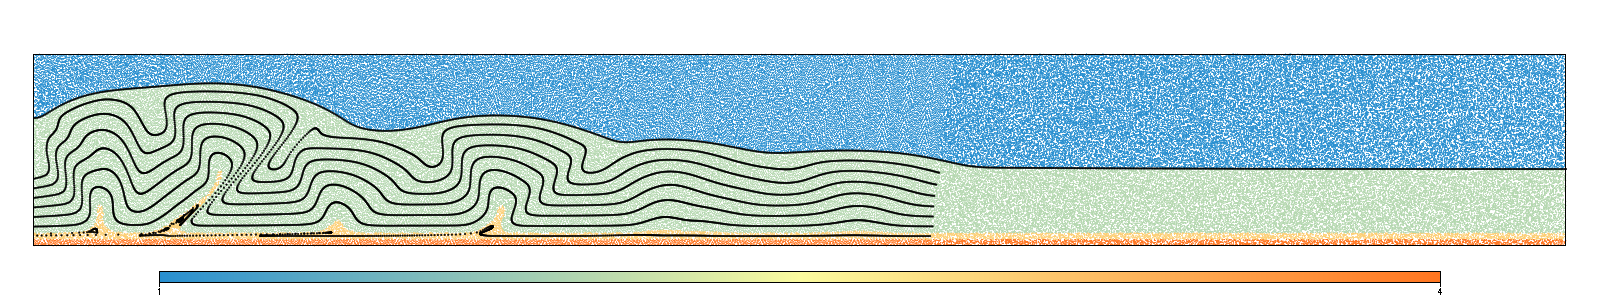

In [ ]:
Fig = glucifer.Figure(figsize=(1600,300))
topoInterface = Model.add_passive_tracers(name="Interface2", vertices=[gridt[0], gridt[1]])
Fig.Points(topoInterface.swarm, pointSize=3.0)
Fig.Points(in2.swarm, pointSize=3.0)
Fig.Points(in1.swarm, pointSize=3.0)
Fig.Points(in3.swarm, pointSize=3.0)
Fig.Points(in4.swarm, pointSize=3.0)
Fig.Points(in5.swarm, pointSize=3.0)
Fig.Points(in6.swarm, pointSize=3.0)
Fig.Points(in7.swarm, pointSize=3.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.save(Model.outputDir+"/Materialnandpassivetracers.png")

Fig.show()


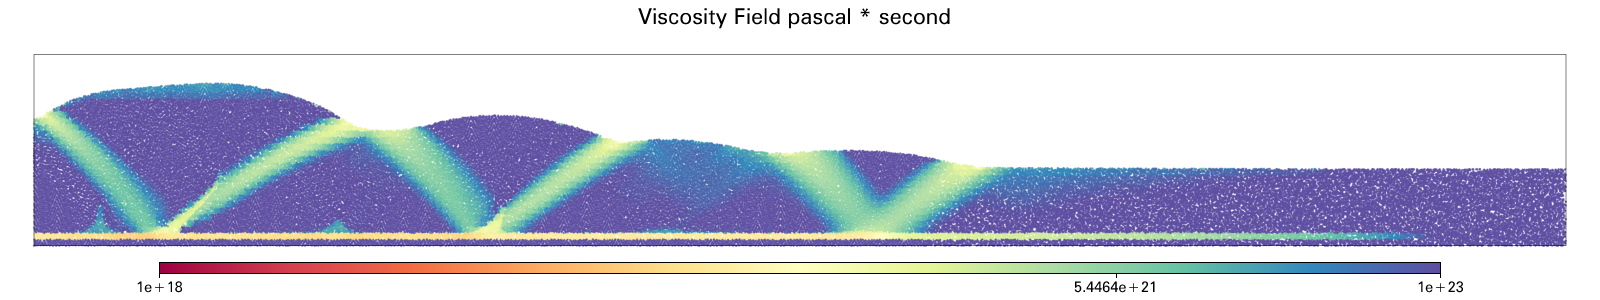


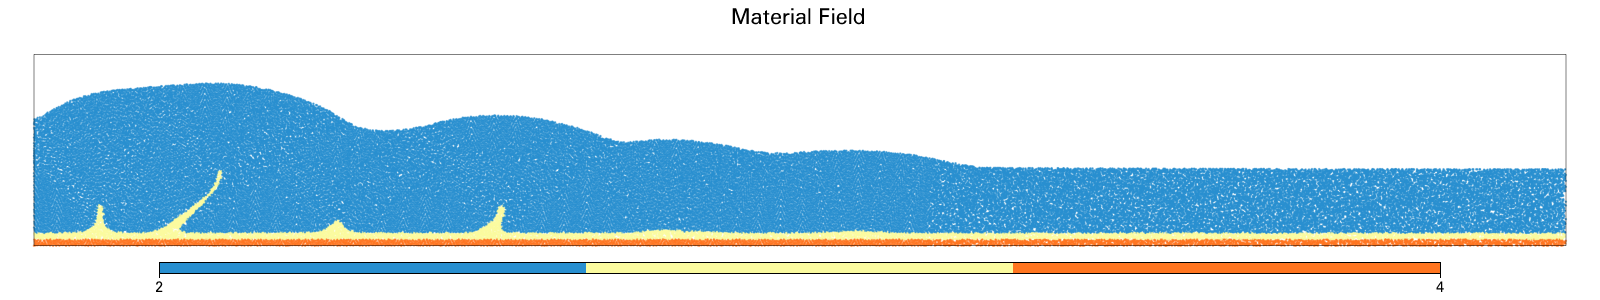


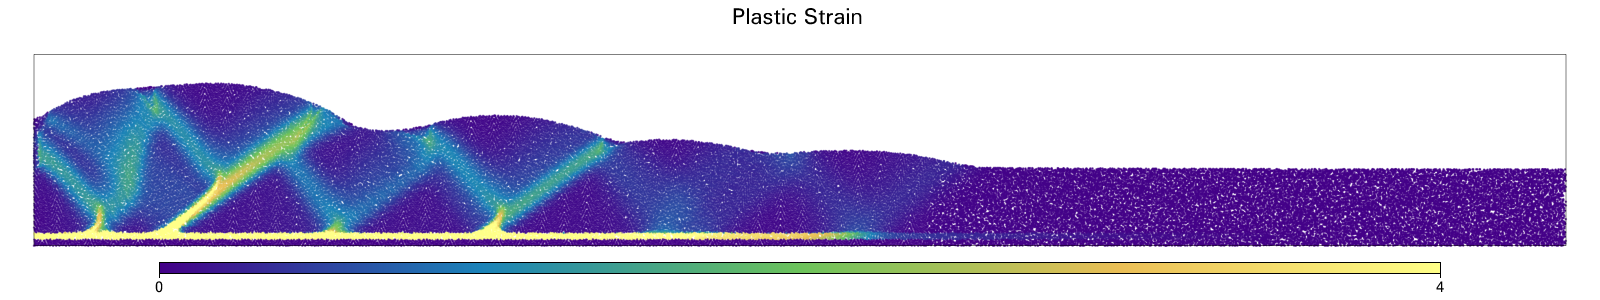


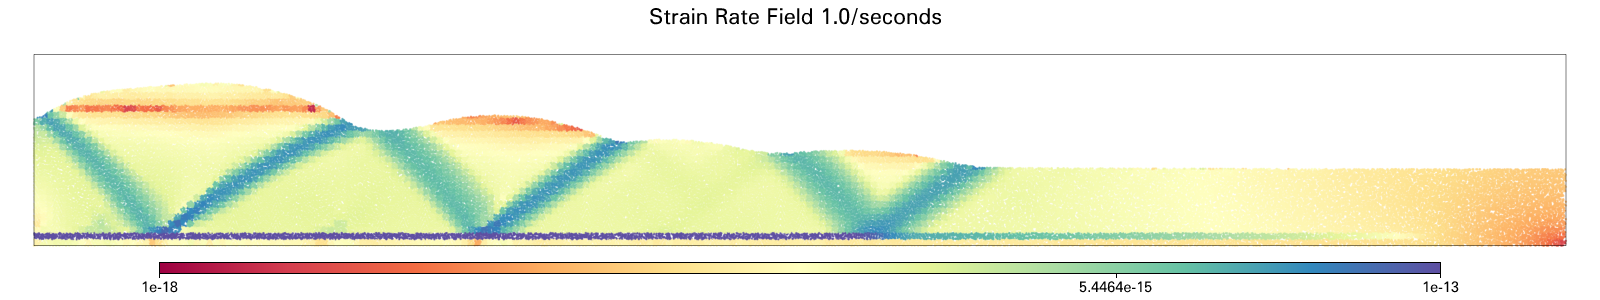

In [ ]:
plotFigures(fnSize=3)